This test should display building statistics All Buildings:
Total records: 7200
Average Energy Usage: 277.87
Average Temperature: 12.45
Average Humidity: 59.83
This test should display first few rows of dataframe with time of day & tempf column:
             Timestamp Building_ID  Energy_Usage (kWh)  Temperature (C)  \
0  2025-01-01 00:00:00        B001              121.30            -7.20   
1  2025-01-01 01:00:00        B001              230.76            12.62   
2  2025-01-01 02:00:00        B001              187.21            -1.33   
3  2025-01-01 03:00:00        B001              262.23             0.24   
4  2025-01-01 04:00:00        B001              472.97             5.44   

   Humidity (%) Building_Type Occupancy_Level TimeOfDay   TempF  
0         79.36    Industrial             Low     night  19.040  
1         80.37    Industrial            High     night  54.716  
2         37.74    Industrial            High     night  29.606  
3         39.97    Industrial          

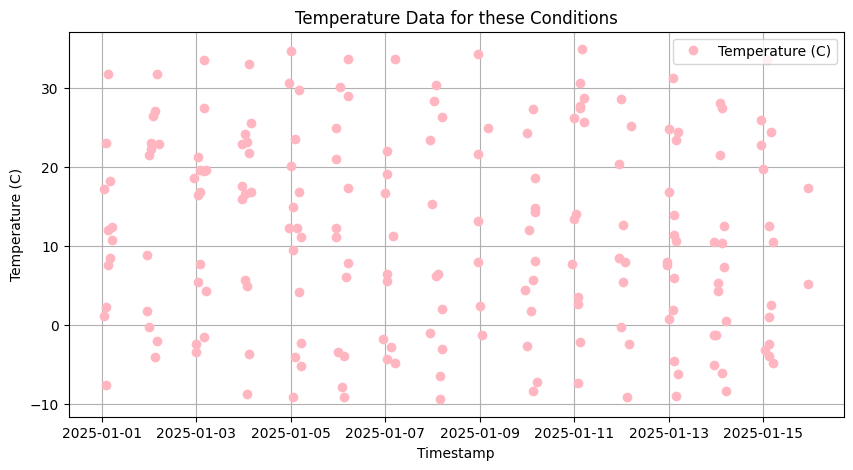

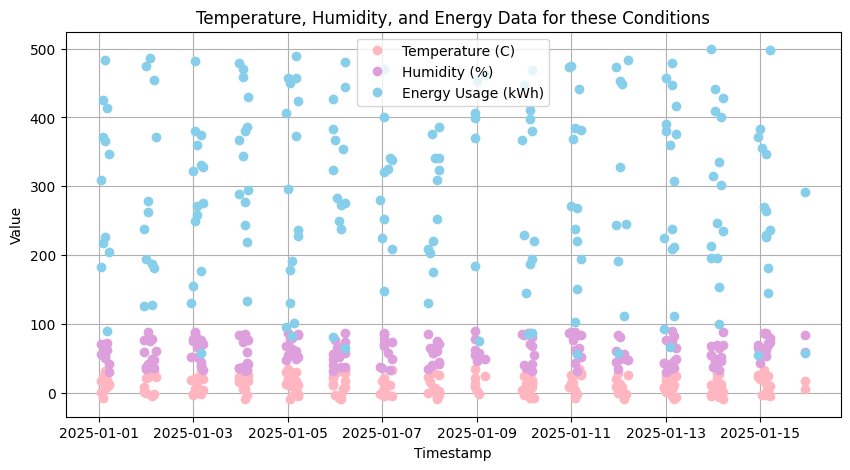

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Building:
    def __init__(self, dataframe):
        # sets up the full dataset rather than just the selected one
        #PANDAS Dataframe is mutable
        self.df = dataframe.copy()

        # storing lists of all the data - looks at columns and pulls them as attributes
        self.timestamps = self.df["Timestamp"]
        self.energy = pd.to_numeric(self.df["Energy_Usage (kWh)"], errors="coerce")
        self.temperature = pd.to_numeric(self.df["Temperature (C)"], errors="coerce")
        self.humidity = pd.to_numeric(self.df["Humidity (%)"], errors="coerce")
        self.occupancy = self.df["Occupancy_Level"]
        self.building_type = self.df["Building_Type"]
        
    def __len__(self): #operator overloading for len() function
        return len(self.df)

    def __str__(self): # returns a readable string summarizing dataset for checking, #len() is also a built in module/library
        return (
            f"Total records: {len(self)}\n"
            f"Average Energy Usage: {self.energy.mean():.2f}\n"
            f"Average Temperature: {self.temperature.mean():.2f}\n"
            f"Average Humidity: {self.humidity.mean():.2f}"
        )

    

# Load data
df = pd.read_csv("building_energy_data_extended.csv")

#The dictionary of buildings is an mutable object
buildings = {"ALL": Building(df)}

class BuildingCalc:
    """
    This class has a composition relationship with the Building class. 
    Ex. Week 12 Composition Slides: "has-a" relationship
    Class function is to calculate estimates for energy, temp, humidity based
    on inputs of: building type, occupancy level, and time
    """
    def __init__(self, building):
        #this is a constructor.
        #Storing the building instance in this separate class.
        self.building = building #composition within this class to the previous class
        # dataframe from the building instance.
        df = self.building.df.copy()
        #Filtering the data to create a new timeofday column (separates timestamps)
        df["TimeOfDay"] = df["Timestamp"].apply(self._categorize_time)
        # getting the data in Fahrenheit rather than Celcius 
        df["TempF"] = [temp * 9/5 + 32 for temp in df["Temperature (C)"]] # list comprehension
        self.df = df
        

    def _categorize_time(self, ts):
        #This function works by sorting the timestamps into morning, afternoon, evening, night
        hour = pd.to_datetime(ts).hour

        if 6 <= hour < 12:
            return "morning"
        elif 12 <= hour < 17:
            return "afternoon"
        elif 17 <= hour < 23:
            return "evening"
        else:
            return "night"
        
    #Determines the avg energy, temp, humidity given the:
    #Building type, occupancy level, and time period
    def estimate(self, building_type, occupancy_level, time_period, show_rows = False):
        #Process details:
        #Select all rows which fulfill the filter requirements
        # Use filter + lambda to select matching rows
        # Source: Week 14 – Built-in functions (filter, lambda)
        filtered = pd.DataFrame(
            #Filter is an example of a built in module/functionality
            filter(
                lambda row: 
                (row["Building_Type"] == building_type and row["Occupancy_Level"] == occupancy_level and row["TimeOfDay"] == time_period), self.df.to_dict("records"))
        )

        #State there is no data for this case, if there is no match- using valueerror
        if filtered.empty:
            raise ValueError("No data available for the given parameters.")
        

        #This if statement is for testing to ensure the correct data rows are used for testing
        #if show_rows:
        #    print("Filtered DataFrame used for calculation:")
        #    print(filtered)
        #    print()

        #Calc the average of filtered datasets
        return {
            "Estimated Energy (kWh)": filtered["Energy_Usage (kWh)"].mean(),
            "Estimated Temperature (C)": filtered["Temperature (C)"].mean(),
            "Estimated Temperature (F)": filtered["TempF"].mean(),
            "Estimated Humidity (%)": filtered["Humidity (%)"].mean(),
            "Energy Minimum (kWh)": filtered["Energy_Usage (kWh)"].min(),
            "Energy Maximum (kWh)": filtered["Energy_Usage (kWh)"].max()
        } 
    def row_check(self, building_type, occupancy_level, time_period):
        #Generator function to show rows matching criteria input by user
        for row in self.df.to_dict("records"):
            if (
                row["Building_Type"] == building_type and 
                row["Occupancy_Level"] == occupancy_level and 
                row["TimeOfDay"] == time_period
            ):
                yield row


#Commented. Was used to test and ensure specific buildings were imported correctly.
# For loop to group dataset by Building_ID
#for building_id, group in df.groupby("Building_ID"):
#    building_type = group["Building_Type"].iloc[0]

#    b = Building(building_id, building_type)
#    b.recording_data(group)

#    buildings[building_id] = b



if __name__ == "__main__": # protects the main running function

    
    # while loop to let user choose what building stats they wanna see
    while True:
        user_input = input("Enter 'ALL' to see dataset stats ('X' to exit): ").strip()
        if user_input.lower() == 'x':
            break
        elif user_input in buildings:
            print(buildings[user_input])
        else:
            try:
                raise ValueError(f"Invalid Building ID entered: '{user_input}'")
            except ValueError as e:
                print("Error:", e)


#TESTING SECTION:
#Test for the __str__
test_building = buildings["ALL"]
print("This test should display building statistics All Buildings:")
print(test_building)

#Test for building calc class
calc = BuildingCalc(test_building)
print("This test should display first few rows of dataframe with time of day & tempf column:")
print(calc.df.head())

#Test estimate avg functionality:
print("This should pring the avg energy, temp, humidity for given param")
result = calc.estimate(building_type="Industrial", occupancy_level="High", time_period="afternoon", show_rows = True)
print(result)

# updated to work with the new building & buildingcalc classes
print()
while True:
    try:
        # this asks the user to enter the building type, occupancy level, and time of day they want to see the avg energy for... 
        
        # for reference: 
        #(row["Building_Type"] == building_type and row["Occupancy_Level"] == occupancy_level and row["TimeOfDay"] == time_period)
        
        # allow user to enter building type or number corresponding (streamlined)
        user_build = input("Enter a building type (1 - Industrial, 2 - Commercial, 3 - Residential, 4 - Educational) ('X or x' to exit):").strip()
        if user_build == 'X' or user_build == 'x': # check if want exit/cancel
            break
        valid_builds = ["1", "2", "3", "4", "Industrial", "Commercial", "Residential", "Educational"] 
        # accepts both numbers and words so user can do whichever they want

        if user_build not in valid_builds: # raise an error if user's input is invalid
            raise ValueError("Invalid building entered.")
        
        # sets the numbers back to the word values 
        if user_build == "1": user_build = "Industrial"
        elif user_build == "2": user_build = "Commercial"
        elif user_build == "3": user_build = "Residential"
        elif user_build == "4": user_build = "Educational"


        # allow user to enter occupancy levels (repeat steps above)
        user_occ = input("Enter an occupancy level (1 - High, 2 - Medium, 3 - Low) ('X or x' to exit):").strip()
        if user_occ == 'X' or user_occ == 'x':
            break
        valid_occs = ["1", "2", "3", "High", "Medium", "Low"]
        if user_occ not in valid_occs:
            raise ValueError("Invalid level entered.")
        
        if user_occ == "1": user_occ = "High"
        elif user_occ == "2": user_occ = "Medium"
        elif user_occ == "3": user_occ = "Low"
        

        # allow user to enter time of day (repeat steps above)
        user_time = input("Enter a time of day (1 - morning, 2 - afternoon, 3 - evening, 4 - night) ('X or x' to exit):").strip()
        if user_time == 'X' or user_time == 'x':
            break
        #VALID_TIMES is a constant tuple- which is immutable
        VALID_TIMEOFDAY = ("morning", "afternoon", "evening", "night")
        valid_times = ("1", "2", "3", "4") + VALID_TIMEOFDAY
        if user_time not in valid_times:
            raise ValueError("Invalid time of day entered.")
        
        if user_time == "1": user_time = "morning"
        elif user_time == "2": user_time = "afternoon"
        elif user_time == "3": user_time = "evening"
        elif user_time == "4": user_time = "night"


        # the average energy for all of the user specified conditions
        avg_energy = calc.estimate(building_type = user_build, occupancy_level = user_occ, time_period = user_time)
        # get the estimated energy value from returned dict value
        avg_energy_value = avg_energy['Estimated Energy (kWh)']

        # show range of values for the users values
        # lower limit
        min_energy = calc.estimate(building_type = user_build, occupancy_level = user_occ, time_period = user_time)
        min_energy_value = min_energy['Energy Minimum (kWh)']

        # upper limit
        max_energy = calc.estimate(building_type = user_build, occupancy_level = user_occ, time_period = user_time)
        max_energy_value = max_energy['Energy Maximum (kWh)']

        # clean lines for the user to read what is going on
        print(f"Average energy consumption (kWh) for {user_build} type with {user_occ} people in the {user_time}: {avg_energy_value:.2f} kWh")
        print(f"the energy values fall in a range from {min_energy_value} to {max_energy_value} kWh")

        #print from generator function the rows matching criteria
        print("\nRows matching selected criteria:\n")



        # empty shells for the data to store data from calc.row_check
        timestamps = []
        temperature = []
        humidity = []
        energy = []

        # looping through filtered rows 
        for row in calc.row_check(
            building_type=user_build,
            occupancy_level=user_occ,
            time_period=user_time
            ):
            print(row) # shows the row for verification

            # appending each data point to its list
            timestamps.append(row['Timestamp'])
            temperature.append(row['Temperature (C)'])
            humidity.append(row['Humidity (%)'])
            energy.append(row['Energy_Usage (kWh)'])

        # creating the DataFrame from lists
        df = pd.DataFrame({
            'Timestamp': timestamps,
            'Temperature': temperature,
            'Humidity': humidity,
            'Energy': energy
        })

        # converting the timestamp to datetime for sorting in order of time
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df.sort_values('Timestamp', inplace = True) # sort the values


        # plotting temperature only (can later be implemented for each value)
        plt.figure(figsize = (10, 5))
        plt.plot(df['Timestamp'], df['Temperature'], marker = 'o', color = 'lightpink', linestyle = 'None', label = 'Temperature (C)')
                
        plt.title("Temperature Data for these Conditions")
        plt.xlabel("Timestamp")
        plt.ylabel("Temperature (C)")
        plt.legend()
        plt.grid(True)
        plt.show()
        

        # ploting all variables
        plt.figure(figsize = (10, 5))
        plt.plot(df['Timestamp'], df['Temperature'], marker = 'o', color = 'lightpink', linestyle = 'None', label = 'Temperature (C)')
        plt.plot(df['Timestamp'], df['Humidity'], marker = 'o', color = 'plum', linestyle = 'None', label = 'Humidity (%)')
        plt.plot(df['Timestamp'], df['Energy'], marker = 'o', color = 'skyblue', linestyle = 'None', label = 'Energy Usage (kWh)')

        plt.title("Temperature, Humidity, and Energy Data for these Conditions")
        plt.xlabel("Timestamp")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()


    except ValueError as e:
        print("Error:", e) # something happened